# Web Scraping
This notebook will be used to fetch transcripts from Khan Academy (and maybe other MOOC sites in the future)  
It will use the python requests and BeautifulSoup libraries to fetch html documents and parse them  
  
### The Plan:
Khan Academy has many courses divided into several domains (math, science, humanities, computing, economics, etc). The plan is the have a csv that has the video titles + transcripts for each domain that we can load with pandas. Below I will quickly describe how Khan Academy structures their courses then show how I think we could format our dataframes:  
  
Khan Academy has many **domains**, but I don't think having lectures from 3rd / 4th grade lectures will be useful right now, so I will only be briniging in the following domains:
- MATH: HIGH SCHOOL & COLLEGE
- SCIENCE
- COMPUTING
- ARTS & HUMANITIES
- ECONOMICS
  
Each domain then has several **courses**. Some examples from the `MATH: HIGH SCHOOL & COLLEGE` domain include:
- Statistics & probability
- College algebra
- Multivariable calculus
- Differential equations
- ...
  
Then, each course includes several **units**. For example, the `Differential equations` course has the following units:
- First order differential equations
- Second order linear equations
- Laplace transform

Each unit has several **lessons**. For example, the `Laplace transform` unit has the following lessons:
- Laplace transform
- Properties of the Laplace transform
- Laplace transform to solve a differential equation
- The convolution integral

Finally, each lesson has multiple videos / articles. This is what we will be grabbing the text / transcript of. Each video also has an 'About' section which I believe could serve like a mini summary. The `The convolution integral` lesson has the following videos:
- Introduction to the convolution
- The convolution and the Laplace transform
- Using the convolution theorem to solve an initial value prob
  
So, the section of our `MATH` csv with the `The convolution integral` lesson will be formatted like this:  
  
| course                 | unit              | lesson                   | video_title                                                  | about | transcript |
|------------------------|-------------------|--------------------------|--------------------------------------------------------------|-------|------------|
| Differential equations | Laplace transform | The convolution integral | Introduction to the convolution                              | ...   | ...        |
| Differential equations | Laplace transform | The convolution integral | The convolution and the Laplace transform                    | ...   | ...        |
| Differential equations | Laplace transform | The convolution integral | Using the convolution theorem to solve an initial value prob | ...   | ...        |
| ...                    | ...               | ...                      | ...                                                          | ...   | ...        |

In [1]:
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import pandas as pd
import requests
import time
import re

In [2]:
math = requests.get(url = 'https://www.khanacademy.org/math').text
science = requests.get(url = 'https://www.khanacademy.org/science').text
computing = requests.get(url = 'https://www.khanacademy.org/science').text
humanities = requests.get(url = 'https://www.khanacademy.org/humanities').text
econ = requests.get(url = 'https://www.khanacademy.org/economics-finance-domain').text

In [3]:
soup = BeautifulSoup(econ, 'html.parser')

## Courses

In [4]:
def filter_course_tags(tag):
    return tag.name == 'a' and \
    not tag.has_attr('aria-label') and \
    '_dwmetq' in tag.attrs['class'] and \
    re.compile('^(?!https).*$').match(tag.attrs['href'])

In [5]:
course_tags = soup.find_all(filter_course_tags)

In [6]:
for tag in course_tags:
    print(tag.text,' : ',tag.attrs['href'])

Macroeconomics  :  /economics-finance-domain/macroeconomics
AP®︎/College Macroeconomics  :  /economics-finance-domain/ap-macroeconomics
Microeconomics  :  /economics-finance-domain/microeconomics
AP®︎/College Microeconomics  :  /economics-finance-domain/ap-microeconomics
Finance and capital markets  :  /economics-finance-domain/core-finance


## Units

In [7]:
macro = requests.get(url = 'https://www.khanacademy.org/economics-finance-domain/economics-finance-domain/macroeconomics').text

In [8]:
soup_c = BeautifulSoup(macro, 'html.parser')

In [9]:
def filter_unit_tags(tag):
    return tag.name == 'a' and \
    not tag.has_attr('aria-label') and \
    '_dwmetq' in tag.attrs['class'] and \
    re.compile('^(?!https).*[^/d]$').match(tag.attrs['href'])

In [10]:
unit_tags = soup_c.find_all(filter_unit_tags)

In [11]:
for tag in unit_tags:
    print(tag.text, ' : ',tag.attrs['href'])

Basic economics concepts  :  /economics-finance-domain/macroeconomics/macro-basic-economics-concepts
Economic indicators and the business cycle  :  /economics-finance-domain/macroeconomics/macro-economic-indicators-and-the-business-cycle
National income and price determination  :  /economics-finance-domain/macroeconomics/aggregate-supply-demand-topic
Financial sector  :  /economics-finance-domain/macroeconomics/monetary-system-topic
Long-run consequences of stabilization policies  :  /economics-finance-domain/macroeconomics/macro-long-run-consequences-of-stabilization-policies
Open economy: international trade and finance  :  /economics-finance-domain/macroeconomics/forex-trade-topic
Keynesian approaches and IS-LM  :  /economics-finance-domain/macroeconomics/income-and-expenditure-topic
Contemporary macroeconomic issues  :  /economics-finance-domain/macroeconomics/macroeconomics-income-inequality


## Lessons

In [12]:
basic = requests.get(url = 'https://www.khanacademy.org/economics-finance-domain/macroeconomics/macro-basic-economics-concepts').text

In [13]:
soup_u = BeautifulSoup(basic, 'html.parser')

In [14]:
def filter_lesson_tags(tag):
    return 'data-test-id' in tag.attrs and \
    tag.attrs['data-test-id'] == 'lesson-card-link'

In [15]:
lesson_tags = soup_u.find_all(filter_lesson_tags)

In [16]:
for tag in lesson_tags:
    print(tag.text,' : ',tag.attrs['href'],'\n')

Introduction to macroeconomics  :  /economics-finance-domain/macroeconomics/macro-basic-economics-concepts/macro-scarcity/v/introduction-to-economics 

Opportunity cost and the Production Possibilities Curve  :  /economics-finance-domain/macroeconomics/macro-basic-economics-concepts/macro-opportunity-cost-and-the-production-possibilities-curve/v/production-possibilities-frontier 

Comparative advantage and the gains from trade  :  /economics-finance-domain/macroeconomics/macro-basic-economics-concepts/macro-comparative-advantage-and-the-gains-from-trade/v/comparative-advantage-specialization-and-gains-from-trade 

Demand  :  /economics-finance-domain/macroeconomics/macro-basic-economics-concepts/macro-demand/v/law-of-demand 

Supply  :  /economics-finance-domain/macroeconomics/macro-basic-economics-concepts/macro-supply/v/law-of-supply 

Markets  :  /economics-finance-domain/macroeconomics/macro-basic-economics-concepts/macro-market-equilibrium-disequilibrium-and-changes-in-equilibrium

## Transcripts

In [17]:
intro = requests.get(url = 'https://www.khanacademy.org/economics-finance-domain/macroeconomics/macro-basic-economics-concepts/macro-scarcity/v/introduction-to-economics').text

In [18]:
soup_l = BeautifulSoup(intro, 'html.parser')

In [19]:
def filter_video_tags(tag):
    return tag.name == 'a' and \
    '_5tdxkjz' in tag.attrs['class'] and \
    'data-test-id' not in tag.attrs and \
    re.compile('\/v\/').search(tag.attrs['href']) #/v/ are videos, /a/ are articles, /e/ are exercises

In [20]:
video_tags = soup_l.find_all(filter_video_tags)

In [21]:
for tag in video_tags:
    print(tag.text,' : ',tag.attrs['href'],'\n')

Introduction to economics  :  /economics-finance-domain/macroeconomics/macro-basic-economics-concepts/macro-scarcity/v/introduction-to-economics 

Scarcity  :  /economics-finance-domain/macroeconomics/macro-basic-economics-concepts/macro-scarcity/v/scarcity 

Normative and positive statements  :  /economics-finance-domain/macroeconomics/macro-basic-economics-concepts/macro-scarcity/v/normative-and-positive-statements 

Economic models  :  /economics-finance-domain/macroeconomics/macro-basic-economics-concepts/macro-scarcity/v/economic-models 

Command and market economies  :  /economics-finance-domain/macroeconomics/macro-basic-economics-concepts/macro-scarcity/v/command-and-market-economies 



In [22]:
vid = requests.get(url = 'https://www.khanacademy.org/economics-finance-domain/macroeconomics/macro-basic-economics-concepts/macro-scarcity/v/introduction-to-economics').text

In [23]:
soup_v = BeautifulSoup(vid, 'html.parser')

In [24]:
soup_v.find_all(class_='_1fezbb8')[0].text

'As we begin our journey into the world of economics, I thought I would begin with a quote from one of the most famous economists of all time, the Scottish philosopher Adam Smith. And he really is kind of the first real economist in the way that we view it now. And this is from his The Wealth of Nations, published in 1776, coincidentally, the same year as the American Declaration of Independence, and it\'s one of his most-famous excerpts. He generally indeed, he being an economic actor, neither intends to promote the public interest, nor knows how much he is promoting it. By directing that industry, so that the industry in control of that individual actor in such a manner, as its produce may be of the greatest value, he intends only his own gain. \'He intends only his own gain\'. And he is in this, as in many other cases, led by an invisible hand to promote an end which was no part of his intention. And this term "the invisible hand" is famous. Led by an invisible hand to promote an en

In [25]:
soup_v.find_all(class_='_e4x16a')[0].text

'In this video, we introduce the field of economics using quotes from the person that many consider to be the "father" of economics: Adam Smith. Topics include the definition of economics, microeconomics, and macroeconomics as a field and the role of assumptions in economic decisionmaking. Created by Sal Khan.'

# Putting it all together  
### Define Filters  
Only grabbing video (/v/) transcripts right now

In [26]:
def filter_course_tags(tag):
    return tag.name == 'a' and \
    not tag.has_attr('aria-label') and \
    '_dwmetq' in tag.attrs['class'] and \
    re.compile('^(?!https).*$').match(tag.attrs['href'])

def filter_unit_tags(tag):
    return tag.name == 'a' and \
    not tag.has_attr('aria-label') and \
    '_dwmetq' in tag.attrs['class'] and \
    re.compile('^(?!https).*[^/d]$').match(tag.attrs['href'])

def filter_lesson_tags(tag):
    return 'data-test-id' in tag.attrs and \
    tag.attrs['data-test-id'] == 'lesson-card-link'

def filter_video_tags(tag):
    return tag.name == 'a' and \
    '_5tdxkjz' in tag.attrs['class'] and \
    'data-test-id' not in tag.attrs and \
    re.compile('\/v\/').search(tag.attrs['href']) #/v/ are videos, /a/ are articles, /e/ are exercises

### Traverse a domain and grab all transcripts

In [31]:
def generate_frame(df, domain_url):
    domain_page = requests.get(url = domain_url).text
    soup_domain = BeautifulSoup(domain_page, 'html.parser')
    course_tags = soup_domain.find_all(filter_course_tags)
    for tag in course_tags:
        time.sleep(delay)
        get_units(df, tag.text, tag.attrs['href'])
                   
def get_units(df, course_name, course_url):
    course_url = 'https://www.khanacademy.org' + course_url 
    course_page = requests.get(url = course_url).text
    soup_course = BeautifulSoup(course_page, 'html.parser')
    unit_tags = soup_course.find_all(filter_unit_tags)
    for tag in unit_tags:
        time.sleep(delay)
        get_lessons(df, course_name, tag.text, tag.attrs['href'])
                
def get_lessons(df, course_name, unit_name, unit_url):
    unit_url = 'https://www.khanacademy.org' + unit_url
    unit_page = requests.get(url = unit_url).text
    soup_unit = BeautifulSoup(unit_page, 'html.parser')
    lesson_tags = soup_unit.find_all(filter_lesson_tags)
    for tag in lesson_tags:
        time.sleep(delay)
        get_video_pages(df, course_name, unit_name, tag.text, tag.attrs['href'])
                
def get_video_pages(df, course_name, unit_name, lesson_name, lesson_url):
    lesson_url = 'https://www.khanacademy.org' + lesson_url
    lesson_page = requests.get(url = lesson_url).text
    soup_lesson = BeautifulSoup(lesson_page, 'html.parser')
    try:
        video_tags = soup_lesson.find_all(filter_video_tags)
        for tag in video_tags:
            get_transcript(df, course_name, unit_name, lesson_name, tag.text, tag.attrs['href'])
    except(KeyError):
        print('Error grabbing video_tags on lesson:',lesson_name,'at:',lesson_url)
        
def get_transcript(df, course_name, unit_name, lesson_name, video_title, video_url):
    video_url = 'https://www.khanacademy.org' + video_url
    video_page = requests.get(url = video_url).text
    soup_video = BeautifulSoup(video_page, 'html.parser')
    try:
        transcript = soup_video.find_all(class_='_1fezbb8')[0].text
        try:
            about = soup_video.find_all(class_='_e4x16a')[0].text
            df.loc[len(df.index)] = [course_name, unit_name, lesson_name, video_title, about, transcript]
            print([course_name,video_title],'- inserted')
        except(IndexError):
            print('About not found on video:',video_title,'at:',video_url)
            df.loc[len(df.index)] = [course_name, unit_name, lesson_name, video_title, 'n/a', transcript]
            print([course_name,video_title],'- inserted w/o About')
    except(IndexError):
        print('Transcript not found on video:',video_title,'at:',video_url)

In [32]:
df = pd.DataFrame(columns=['course','unit','lesson','video_title','about','transcript'])
df.head()

,course,unit,lesson,video_title,about,transcript


In [33]:
delay = .5 #Try not to get ip banned from khan academy
generate_frame(df,'https://www.khanacademy.org/economics-finance-domain')

['Macroeconomics', 'Introduction to economics'] - inserted
['Macroeconomics', 'Scarcity'] - inserted
['Macroeconomics', 'Normative and positive statements'] - inserted
['Macroeconomics', 'Economic models'] - inserted
['Macroeconomics', 'Command and market economies'] - inserted
['Macroeconomics', 'Production possibilities curve'] - inserted
['Macroeconomics', 'Opportunity cost'] - inserted
['Macroeconomics', 'Increasing opportunity cost'] - inserted
['Macroeconomics', 'PPCs for increasing, decreasing and constant opportunity cost'] - inserted
['Macroeconomics', "Production Possibilities Curve as a model of a country's economy"] - inserted
['Macroeconomics', 'Comparative advantage, specialization, and gains from trade'] - inserted
['Macroeconomics', 'Comparative advantage and absolute advantage'] - inserted
['Macroeconomics', 'Opportunity cost and comparative advantage using an output table'] - inserted
['Macroeconomics', 'Terms of trade and the gains from trade'] - inserted
['Macroecon

['Macroeconomics', 'Causes of shifts in currency supply and demand curves'] - inserted
['Macroeconomics', 'Introduction to currency exchange and trade'] - inserted
['Macroeconomics', 'Consumption function basics'] - inserted
['Macroeconomics', 'Generalized linear consumption function'] - inserted
['Macroeconomics', 'Consumption function with income dependent taxes'] - inserted
['Macroeconomics', 'Keynesian cross'] - inserted
['Macroeconomics', 'Details on shifting aggregate planned expenditures'] - inserted
['Macroeconomics', 'Keynesian cross and the multiplier'] - inserted
['Macroeconomics', 'Investment and real interest rates'] - inserted
['Macroeconomics', 'Connecting the keynesian cross to the IS curve'] - inserted
['Macroeconomics', 'Loanable funds interpretation of IS curve'] - inserted
['Macroeconomics', 'LM part of the IS-LM model'] - inserted
['Macroeconomics', 'Government spending and the IS-LM model'] - inserted
['Macroeconomics', 'Keynesian economics'] - inserted
['Macroeco

['AP®︎/College Macroeconomics', 'Shifts in aggregate demand'] - inserted
['AP®︎/College Macroeconomics', 'Demand-pull inflation under Johnson'] - inserted
['AP®︎/College Macroeconomics', 'Cost-push inflation'] - inserted
['AP®︎/College Macroeconomics', 'Long run self adjustment '] - inserted
['AP®︎/College Macroeconomics', 'Fiscal policy to address output gaps'] - inserted
['AP®︎/College Macroeconomics', 'Calculating change in spending or taxes to close output gaps'] - inserted
['AP®︎/College Macroeconomics', 'Automatic stabilizers'] - inserted
['AP®︎/College Macroeconomics', 'Introduction to interest'] - inserted
['AP®︎/College Macroeconomics', 'Introduction to bonds'] - inserted
['AP®︎/College Macroeconomics', 'Relationship between bond prices and interest rates'] - inserted
['AP®︎/College Macroeconomics', "What it means to buy a company's stock"] - inserted
['AP®︎/College Macroeconomics', 'Bonds vs. stocks'] - inserted
['AP®︎/College Macroeconomics', 'Real and nominal return'] - ins

['Microeconomics', 'Trade and tariffs'] - inserted
['Microeconomics', 'Sample free response question (FRQ) on tariffs and trade'] - inserted
['Microeconomics', 'Marginal utility and total utility'] - inserted
['Microeconomics', 'Visualizing marginal utility MU and total utility TU functions'] - inserted
['Microeconomics', 'Utility maximization: equalizing marginal utility per dollar '] - inserted
['Microeconomics', 'Deriving demand curve from tweaking marginal utility per dollar'] - inserted
['Microeconomics', 'Utility maximization: equalizing marginal utility per dollar '] - inserted
['Microeconomics', 'Marginal utility free response example'] - inserted
['Microeconomics', 'Budget line'] - inserted
['Microeconomics', 'Indifference curves and marginal rate of substitution'] - inserted
['Microeconomics', 'Optimal point on budget line'] - inserted
['Microeconomics', 'Types of indifference curves'] - inserted
['Microeconomics', 'Introduction to production functions '] - inserted
['Microec

['AP®︎/College Microeconomics', 'Fixed, variable, and marginal cost'] - inserted
['AP®︎/College Microeconomics', 'Marginal cost, average variable cost, and average total cost'] - inserted
['AP®︎/College Microeconomics', 'Graphs of MC, AVC and ATC'] - inserted
['AP®︎/College Microeconomics', 'Marginal revenue and marginal cost'] - inserted
['AP®︎/College Microeconomics', 'Marginal revenue below average total cost'] - inserted
['AP®︎/College Microeconomics', 'How costs change when fixed and variable costs change'] - inserted
['AP®︎/College Microeconomics', 'Graphical impact of cost changes on marginal and average costs'] - inserted
['AP®︎/College Microeconomics', 'Long-run average total cost curve'] - inserted
['AP®︎/College Microeconomics', 'Economies and diseconomies of scale'] - inserted
['AP®︎/College Microeconomics', 'Minimum efficient scale and market concentration '] - inserted
['AP®︎/College Microeconomics', 'Economic profit vs accounting profit'] - inserted
['AP®︎/College Microe

['Finance and capital markets', 'Inflation, deflation, and capacity utilization'] - inserted
['Finance and capital markets', 'Inflation, deflation, and capacity utilization 2'] - inserted
['Finance and capital markets', 'Inflation and deflation 3: Obama stimulus plan'] - inserted
['Finance and capital markets', 'Deflation'] - inserted
['Finance and capital markets', 'Velocity of money rather than quantity driving prices'] - inserted
['Finance and capital markets', 'Deflation despite increases in money supply'] - inserted
['Finance and capital markets', 'Deflationary spiral'] - inserted
['Finance and capital markets', 'Basics of US income tax rate schedule'] - inserted
['Finance and capital markets', 'Tax deductions introduction'] - inserted
['Finance and capital markets', 'AMT overview'] - inserted
['Finance and capital markets', 'Alternative minimum tax'] - inserted
['Finance and capital markets', 'Estate tax introduction'] - inserted
['Finance and capital markets', 'Tax brackets and 

['Finance and capital markets', 'Banking 12:  Treasuries (government debt)'] - inserted
['Finance and capital markets', 'Banking 13: Open market operations'] - inserted
['Finance and capital markets', 'Banking 14: Fed funds rate'] - inserted
['Finance and capital markets', 'Banking 15: More on the Fed funds rate'] - inserted
['Finance and capital markets', 'Banking 16: Why target rates vs. money supply'] - inserted
['Finance and capital markets', 'Banking 17: What happened to the gold?'] - inserted
['Finance and capital markets', 'Banking 18: Big picture discussion'] - inserted
['Finance and capital markets', 'The discount rate'] - inserted
['Finance and capital markets', 'Repurchase agreements (repo transactions)'] - inserted
['Finance and capital markets', 'Federal Reserve balance sheet'] - inserted
['Finance and capital markets', 'Fractional Reserve banking commentary 1'] - inserted
['Finance and capital markets', 'FRB commentary 2: Deposit insurance'] - inserted
['Finance and capit

['Finance and capital markets', 'Arbitraging futures contracts II'] - inserted
['Finance and capital markets', 'Futures fair value in the pre-market'] - inserted
['Finance and capital markets', 'Interpreting futures fair value in the premarket'] - inserted
['Finance and capital markets', 'Mortgage-backed security overview'] - inserted
['Finance and capital markets', 'Mortgage-backed securities I'] - inserted
['Finance and capital markets', 'Mortgage-backed securities II'] - inserted
['Finance and capital markets', 'Mortgage-backed securities III'] - inserted
['Finance and capital markets', 'Collateralized debt obligation overview'] - inserted
['Finance and capital markets', 'Collateralized debt obligation (CDO)'] - inserted
['Finance and capital markets', 'Credit default swaps (CDS) intro'] - inserted
['Finance and capital markets', 'Credit default swaps'] - inserted
['Finance and capital markets', 'Credit default swaps 2'] - inserted
['Finance and capital markets', 'Use cases for cred

In [37]:
df.head()

,course,unit,lesson,video_title,about,transcript
0,Macroeconomics,Basic economics concepts,Introduction to macroeconomics,Introduction to economics,"In this video, we introduce the field of econo...",As we begin our journey into the world of econ...
1,Macroeconomics,Basic economics concepts,Introduction to macroeconomics,Scarcity,Dealing with scarcity is the basis of economic...,- [Instructor] The\nentire field of economics ...
2,Macroeconomics,Basic economics concepts,Introduction to macroeconomics,Normative and positive statements,What is the difference between normative and p...,- [Instructor] What we're\ngoing to do in this...
3,Macroeconomics,Basic economics concepts,Introduction to macroeconomics,Economic models,Economic models are a way of taking complicate...,- When you think about what the\nfield of econ...
4,Macroeconomics,Basic economics concepts,Introduction to macroeconomics,Command and market economies,An introduction to the difference between comm...,- [Instructor] In this\nvideo we're gonna talk...


In [20]:
df.to_csv('..\\Datasets\\KhanAcademy\\Economics.csv', index=False)

In [23]:
ls = df['transcript'].apply(lambda x : len(x.split()))

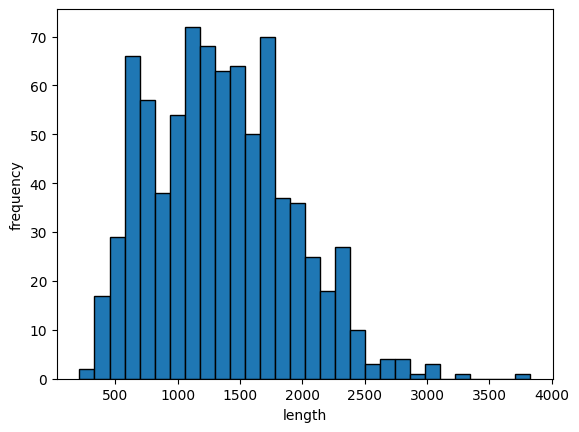

In [24]:
plt.hist(ls,bins=30,edgecolor = "black")
plt.xlabel('length')
plt.ylabel('frequency')
plt.show()